In [459]:
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

videos = list(Path("../data/videos").glob("*.mp4"))

0it [00:00, ?it/s]

1426it [00:02, 705.95it/s]


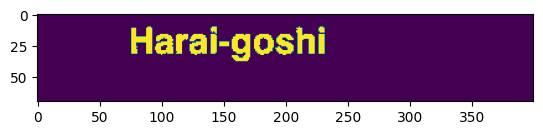

In [460]:
from tqdm import tqdm


def get_frames(cap):
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        yield frame


def get_subset(img, threshold=0.9):
    img = img[630:700, :400]

    # lets binarize based on closeness to white
    t = 255 * threshold
    img = cv2.inRange(img, (t, t, t), (255, 255, 255), img)
    img = cv2.bitwise_not(img)

    # lets also flood fill the background with black from corners
    n = img.shape[0]
    corners = [(0, 0), (0, n - 1), (n - 1, 0), (n - 1, n - 1)]
    for corner in corners:
        cv2.floodFill(img, None, corner, 0)

    # erode the text
    # kernel = np.ones((2, 2), np.uint8)
    # img = cv2.erode(img, kernel, iterations=1)
    return img


video = [v for v in videos if "koshi-waza" in v.name.lower()][0]
cap = cv2.VideoCapture(video.as_posix())
frames = []
for frame in tqdm(get_frames(cap)):
    subset = get_subset(frame, threshold=0.7)
    frames.append(subset)
    # if len(frames) > 25*15: break

plt.imshow(frames[len(frames) // 2])
plt.show()

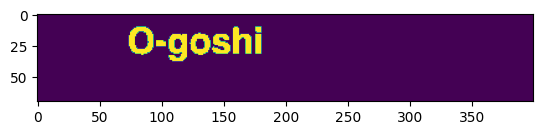

375


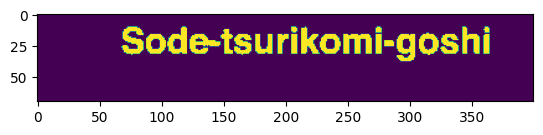

625


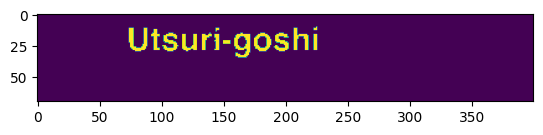

1000


In [461]:
for i in [25 * 15, 25 * 25, 25 * 40]:
    plt.imshow(frames[i])
    plt.show()
    print(i)

In [462]:
# write the frames to disk as a video
frame = frames[0]
writer = cv2.VideoWriter(
    "../data/tmp/frames.mp4",
    cv2.VideoWriter_fourcc(*"avc1"),
    120,
    (frame.shape[1], frame.shape[0]),
)
for i, frame in enumerate(frames):
    # grayscale to color
    frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    writer.write(frame)
writer.release()

1426it [00:01, 745.11it/s]


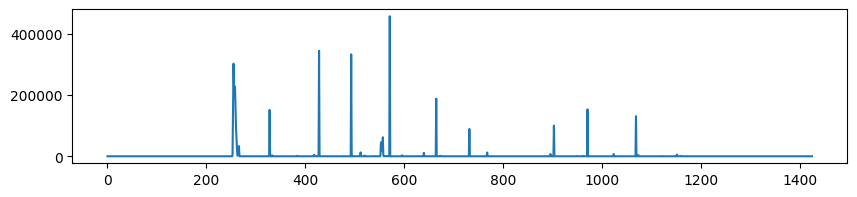

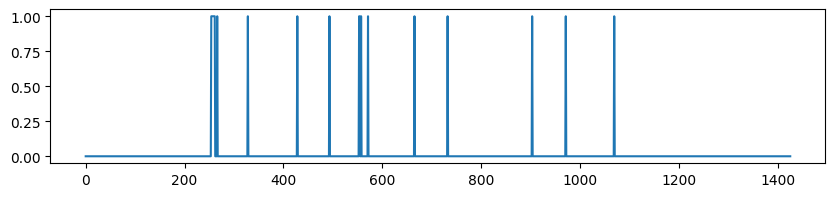

[(266, 327), (328, 427), (428, 492), (493, 552), (571, 664), (665, 731), (732, 902), (903, 970), (971, 1068), (1069, 1159)]


In [463]:
def calculate_intervals(video, threshold=0.9):
    cap = cv2.VideoCapture(video.as_posix())
    frames = []
    for frame in tqdm(get_frames(cap)):
        subset = get_subset(frame, threshold)
        frames.append(subset)

    diffs = [0]
    for i in range(1, len(frames)):
        a, b = frames[i], frames[i - 1]
        score = np.sum(np.abs(a - b))
        diffs.append(score)
    diffs = np.array(diffs)
    scores = (diffs - np.mean(diffs)) / np.std(diffs)

    nonzero = np.where(diffs > 0)[0].tolist()
    points = [nonzero[0]] + np.where(scores > 1)[0].tolist() + [nonzero[-1]]
    intervals = []
    for i in range(1, len(points)):
        a, b = points[i - 1], points[i]
        if b - a > 25:
            intervals.append((a, b - 1))
    return intervals, (diffs, scores)


intervals, (diffs, scores) = calculate_intervals(video, 0.7)
plt.figure(figsize=(10, 2))
plt.plot(diffs)
plt.show()
plt.figure(figsize=(10, 2))
plt.plot(scores > 1)
plt.show()
print(intervals)

In [464]:
# create the folder
def segment(video, dest_root, intervals):
    stem = video.stem.split()[-1].lower()
    dest_dir = dest_root / stem
    dest_dir.mkdir(parents=True, exist_ok=True)
    print(f"Saving clips to {dest_dir}")

    cap = cv2.VideoCapture(video.as_posix())
    writer = None
    interval_idx = 0
    for i, frame in tqdm(enumerate(get_frames(cap))):
        if interval_idx >= len(intervals):
            break
        if writer is None:
            filename = dest_dir / f"{stem}_{interval_idx:02d}.mp4"
            # print(f"Creating {filename}")
            writer = cv2.VideoWriter(
                filename.as_posix(),
                cv2.VideoWriter_fourcc(*"avc1"),
                25,
                (frame.shape[1], frame.shape[0]),
            )
        s, e = intervals[interval_idx]
        if i < s:
            continue
        if i > e:
            interval_idx += 1
            writer.release()
            writer = None
            continue
        writer.write(frame)


dest_root = Path("../data/tmp/clips")
video = [v for v in videos if "koshi-waza" in v.name.lower()][0]
intervals, _ = calculate_intervals(video)
segment(video, dest_root, intervals)

1426it [00:01, 757.80it/s]


Saving clips to ../data/tmp/clips/koshi-waza


1161it [00:03, 295.09it/s]


2180it [00:03, 724.68it/s]0<?, ?it/s]


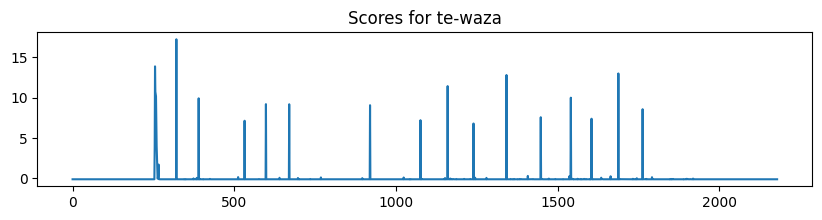

3273it [00:04, 710.95it/s]3<00:21,  3.12s/it]


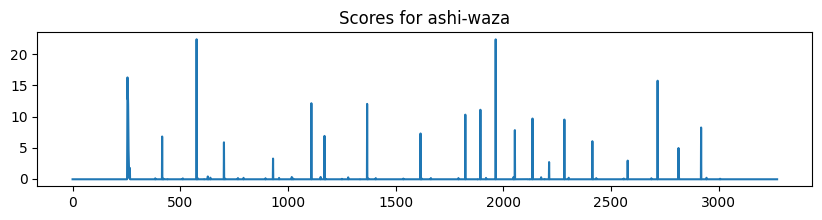

2375it [00:03, 710.73it/s]7<00:24,  4.07s/it]


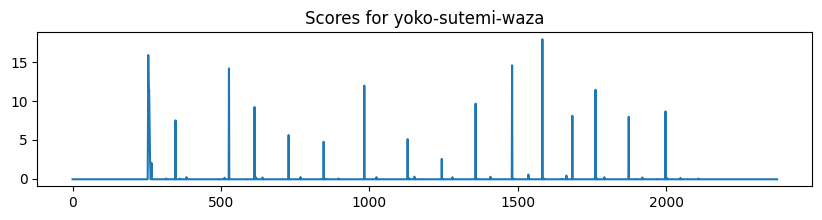

6302it [00:08, 734.42it/s]1<00:18,  3.78s/it]


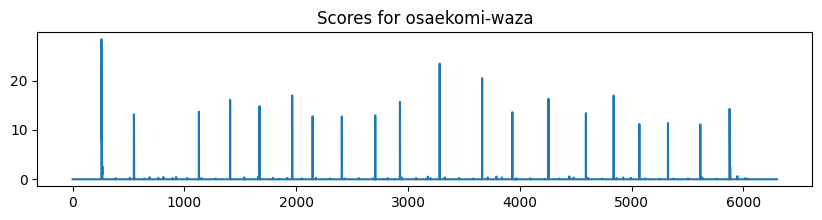

1083it [00:01, 715.96it/s]0<00:22,  5.74s/it]


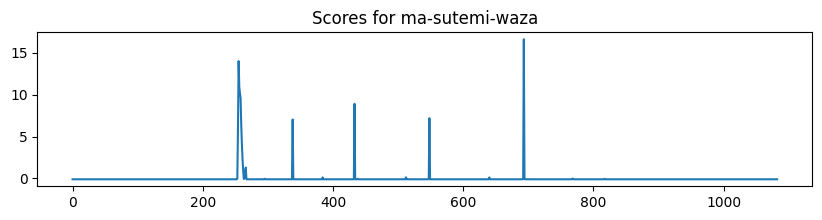

5314it [00:07, 736.28it/s]1<00:12,  4.24s/it]


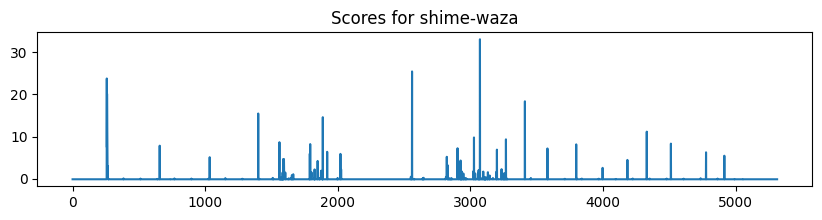

1426it [00:01, 728.11it/s]8<00:10,  5.30s/it]


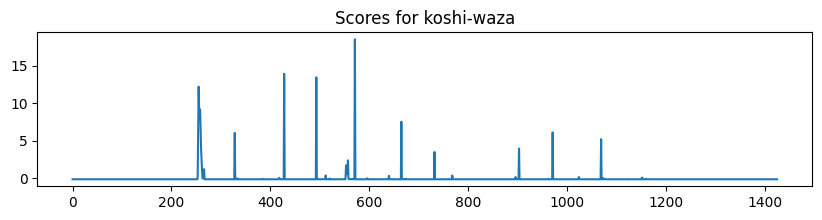

2345it [00:03, 662.11it/s]1<00:04,  4.23s/it]


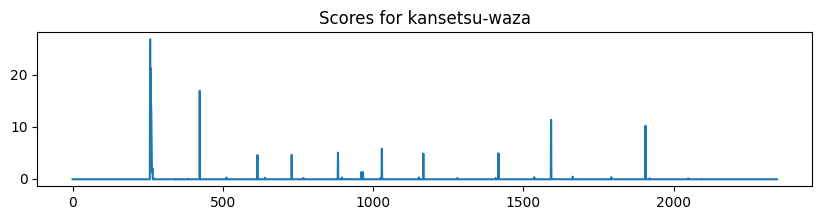

100%|██████████| 8/8 [00:34<00:00,  4.33s/it]
2180it [00:02, 747.48it/s]0<?, ?it/s]


Saving clips to ../data/tmp/clips/te-waza


1920it [00:11, 165.01it/s]
3273it [00:04, 761.51it/s]4<01:42, 14.59s/it]


Saving clips to ../data/tmp/clips/ashi-waza


3008it [00:20, 148.09it/s]
2375it [00:03, 736.42it/s]9<02:03, 20.52s/it]


Saving clips to ../data/tmp/clips/yoko-sutemi-waza


2110it [00:13, 154.82it/s]
6302it [00:08, 737.55it/s]6<01:34, 18.87s/it]


Saving clips to ../data/tmp/clips/osaekomi-waza


6044it [00:47, 127.64it/s]
1083it [00:01, 706.48it/s]2<02:14, 33.52s/it]


Saving clips to ../data/tmp/clips/ma-sutemi-waza


818it [00:04, 193.23it/s]
5314it [00:07, 728.94it/s]7<01:10, 23.52s/it]


Saving clips to ../data/tmp/clips/shime-waza


5056it [00:29, 173.29it/s]
1426it [00:01, 713.28it/s]4<00:55, 27.95s/it]


Saving clips to ../data/tmp/clips/koshi-waza


1161it [00:06, 175.93it/s]
2345it [00:03, 706.31it/s]3<00:21, 21.63s/it]


Saving clips to ../data/tmp/clips/kansetsu-waza


2094it [00:13, 152.66it/s]
100%|██████████| 8/8 [03:00<00:00, 22.53s/it]


In [469]:
dest_root = Path("../data/tmp/clips")
mapping = {"koshi-waza": 0.7}
for video in tqdm(videos):
    name = video.stem.split()[-1].lower()
    intervals, (diffs, scores) = calculate_intervals(
        video, threshold=mapping.get(name, 0.9)
    )
    # a plot of scores, short but wide
    plt.figure(figsize=(10, 2))
    plt.plot(scores)
    plt.title(f"Scores for {name}")
    plt.show()

for video in tqdm(videos):
    name = video.stem.split()[-1].lower()
    intervals, (diffs, scores) = calculate_intervals(
        video, threshold=mapping.get(name, 0.9)
    )
    segment(video, dest_root, intervals)

In [471]:
! ls -lhR ../data/tmp/clips/

total 0
drwxr-xr-x  23 anthony  staff   736B Aug 19 20:51 ashi-waza
drwxr-xr-x  13 anthony  staff   416B Aug 19 20:54 kansetsu-waza
drwxr-xr-x  12 anthony  staff   384B Aug 19 20:53 koshi-waza
drwxr-xr-x   7 anthony  staff   224B Aug 19 20:53 ma-sutemi-waza
drwxr-xr-x  22 anthony  staff   704B Aug 19 20:53 osaekomi-waza
drwxr-xr-x  28 anthony  staff   896B Aug 19 20:53 shime-waza
drwxr-xr-x  18 anthony  staff   576B Aug 19 20:51 te-waza
drwxr-xr-x  18 anthony  staff   576B Aug 19 20:52 yoko-sutemi-waza

../data/tmp/clips//ashi-waza:
total 46280
-rw-r--r--  1 anthony  staff   967K Aug 19 20:51 ashi-waza_00.mp4
-rw-r--r--  1 anthony  staff   1.0M Aug 19 20:51 ashi-waza_01.mp4
-rw-r--r--  1 anthony  staff   925K Aug 19 20:51 ashi-waza_02.mp4
-rw-r--r--  1 anthony  staff   1.4M Aug 19 20:51 ashi-waza_03.mp4
-rw-r--r--  1 anthony  staff   1.3M Aug 19 20:51 ashi-waza_04.mp4
-rw-r--r--  1 anthony  staff   280K Aug 19 20:51 ashi-waza_05.mp4
-rw-r--r--  1 anthony  staff   1.2M Aug 19 20:51 ashi